# Imports

In [1]:
from glob import glob
import matplotlib.pyplot as plt

import torch
import torchvision

import align

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = 'cuda'

# Load images

In [4]:
burst_name = 'portrait_jozef'
image_file_paths = glob(f'test_images/{burst_name}/*.jpg')
images = []
for path in image_file_paths:
    image = torchvision.io.read_image(path)
    image = image.to(device)
    image = image.to(torch.float16) / 255
    image = torchvision.transforms.functional.resize(image, [2000, 1500])
    images.append(image)
images = torch.stack(images)
N, C, H, W = images.shape

# Display images

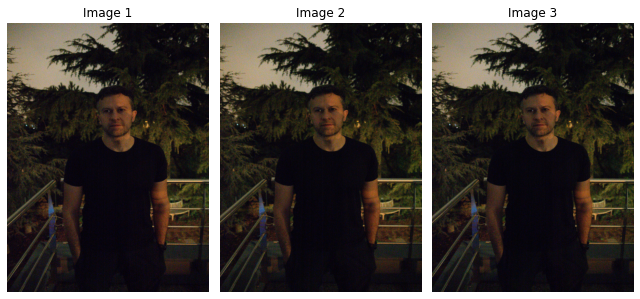

In [5]:
n = 3 # only plot first n images
fig, axs = plt.subplots(1, n, figsize=(3*n, 8))
for i in range(n):
    axs[i].imshow(images[i].to(torch.float32).to('cpu').permute(1, 2, 0))
    axs[i].set_title(f'Image {i+1}')
    axs[i].set_aspect(1)
    axs[i].axis('off')
plt.tight_layout()
plt.show()

# Split images
Split images into a 'reference' image and 'comparison' images which are to be aligned with the 'reference' image.

In [6]:
ref_idx = 0
ref_image = images[ref_idx]
comp_images = images[torch.arange(len(images)) != ref_idx]

# Align images

In [7]:
%%time
downscale_factor_list = [1, 2, 4, 4]
tile_shape_list = [[16, 16], [16, 16], [16, 16], [16, 16]]
search_region_list = [[-1, 1], [-4, 4], [-4, 4], [-4, 4]]
aligned_images = align.align_images(ref_image, comp_images,
                    downscale_factor_list, tile_shape_list, search_region_list)

Wall time: 2.12 s


# Visualize the alignments

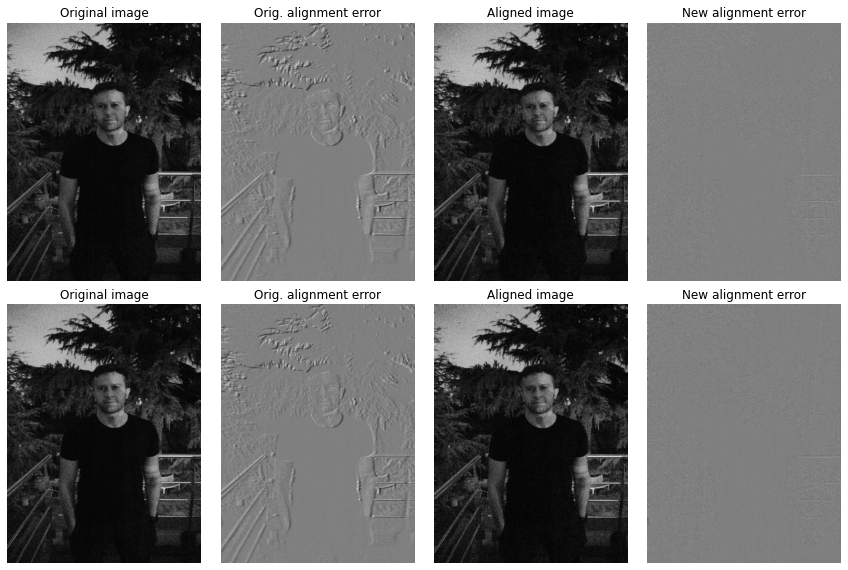

In [8]:
n = 2 # only plot first n alignments
fig, axs = plt.subplots(n, 4, figsize=(3*4, 4*n))
for y in range(len(axs)):
    axs[y, 0].imshow(comp_images[y][0].to('cpu').float(), cmap='gray')
    axs[y, 0].set_title('Original image')
    axs[y, 1].imshow((comp_images[y][0] - ref_image[0]).to('cpu').float(), vmin=-1, vmax=1, cmap='gray')
    axs[y, 1].set_title('Orig. alignment error')
    axs[y, 2].imshow(aligned_images[y][0].to('cpu').float(), cmap='gray')
    axs[y, 2].set_title('Aligned image')
    axs[y, 3].imshow((aligned_images[y][0] - ref_image[0]).to('cpu').float(), vmin=-1, vmax=1, cmap='gray')
    axs[y, 3].set_title('New alignment error')

for ax in axs.flatten():
    ax.set_aspect(1)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Merge images

In [9]:
# TODO: robust merge
merged_image = ref_image + aligned_images.sum(0)
merged_image /= (1 + len(aligned_images))
merged_image = torch.clip(merged_image, 0, 1)

# Plot reference vs. merged image

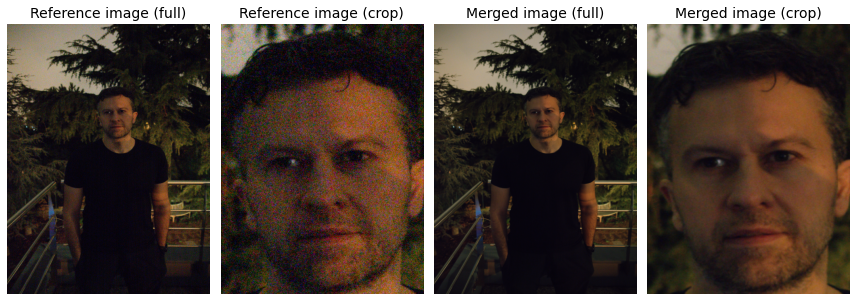

In [10]:
# crop
crop_y = [450, 850]
crop_x = [650, 950]

# reference image
font_size = 14
fig, axs = plt.subplots(1, 4, figsize=[12, 8])
axs[0].imshow(ref_image.to('cpu').float().permute(1, 2, 0))
axs[0].set_title('Reference image (full)', fontsize=font_size)
axs[1].imshow(ref_image[:, crop_y[0]:crop_y[1]:, crop_x[0]:crop_x[1]].to('cpu').float().permute(1, 2, 0))
axs[1].set_title('Reference image (crop)', fontsize=font_size)

# merged burst
axs[2].imshow(merged_image.to('cpu').float().permute(1, 2, 0))
axs[2].set_title('Merged image (full)', fontsize=font_size)
axs[3].imshow(merged_image[:, crop_y[0]:crop_y[1]:, crop_x[0]:crop_x[1]].to('cpu').float().permute(1, 2, 0))
axs[3].set_title('Merged image (crop)', fontsize=font_size)

for ax in axs:
    ax.set_aspect(1)
    ax.axis('off')
plt.tight_layout()
plt.savefig(f'results/{burst_name}.jpg', bbox_inches='tight')
plt.show()